In [2]:
!pip install animus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Весь код библиотеки animus находится [тут](https://github.com/Scitator/animus/blob/main/animus/core.py)

Это простая библиотека, которая дает интерфейс для запуска экспериментов

In [3]:
from typing import Any, Callable, Iterable, NamedTuple, Set, Tuple, Union
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
import seaborn as sns
import torch
import torch.nn.functional as F
from animus import ICallback, IExperiment
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


sns.set(rc={"figure.figsize": (15, 5)})

# Что по данным?

В этом семинаре мы будем экспериментировать с датасетом MovieLens 10M.
Это один из самых известных датасетов для исследования рекомендательных моделей, поэтому вы его ещё не раз встретите в статья.

Датасет на самом деле очень простой. У нас есть user, item и рейтинг user для item. Рейтинг - explicit величина, которая принимает значения от 0 до 5. Кроме того, есть ещё метадата для фильмов, если мы захотим обучить что-то на основе контента. Однако последнее нам не понадобится))

## Step 0: Получим данные

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip
!unzip -uo ml-10m.zip -d data
# Приведем к формату csv ratings
!awk 'BEGIN { print "user,item,values,timestamp" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/ratings.dat > data/ml-10M100K/ratings.csv
# Приведем к формату csv movies
!awk 'BEGIN { print "item,title,genres" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/movies.dat > data/ml-10M100K/movies.csv

--2023-04-19 08:42:42--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  14.3MB/s    in 5.8s    

2023-04-19 08:42:49 (10.9 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]

Archive:  ml-10m.zip
   creating: data/ml-10M100K/
  inflating: data/ml-10M100K/allbut.pl  
  inflating: data/ml-10M100K/movies.dat  
  inflating: data/ml-10M100K/ratings.dat  
  inflating: data/ml-10M100K/README.html  
  inflating: data/ml-10M100K/split_ratings.sh  
  inflating: data/ml-10M100K/tags.dat  


Eeeeeeee

Looks good!!!

Иногда bash команды - отличный инструмент, что с данными все хорошо) 

In [5]:
!head data/ml-10M100K/ratings.csv data/ml-10M100K/movies.csv

==> data/ml-10M100K/ratings.csv <==
user,item,values,timestamp
1,122,5,838985046
1,185,5,838983525
1,231,5,838983392
1,292,5,838983421
1,316,5,838983392
1,329,5,838983392
1,355,5,838984474
1,356,5,838983653
1,362,5,838984885

==> data/ml-10M100K/movies.csv <==
item,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action


## Step 1: Посмотрим на данные... Короче EDA

### 1: Распарсим данные из csv в pandas DataFrame

In [6]:
ratings = pd.read_csv("data/ml-10M100K/ratings.csv")
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings.head().T

,0,1,2,3,4
user,1,1,1,1,1
item,122,185,231,292,316
values,5.0,5.0,5.0,5.0,5.0
timestamp,1996-08-02 11:24:06,1996-08-02 10:58:45,1996-08-02 10:56:32,1996-08-02 10:57:01,1996-08-02 10:56:32


In [7]:
ratings.shape, ratings.user.unique().shape, ratings.item.unique().shape

((10000054, 4), (69878,), (10677,))

### 2: Посмотрим на распределение рейтингов в данных

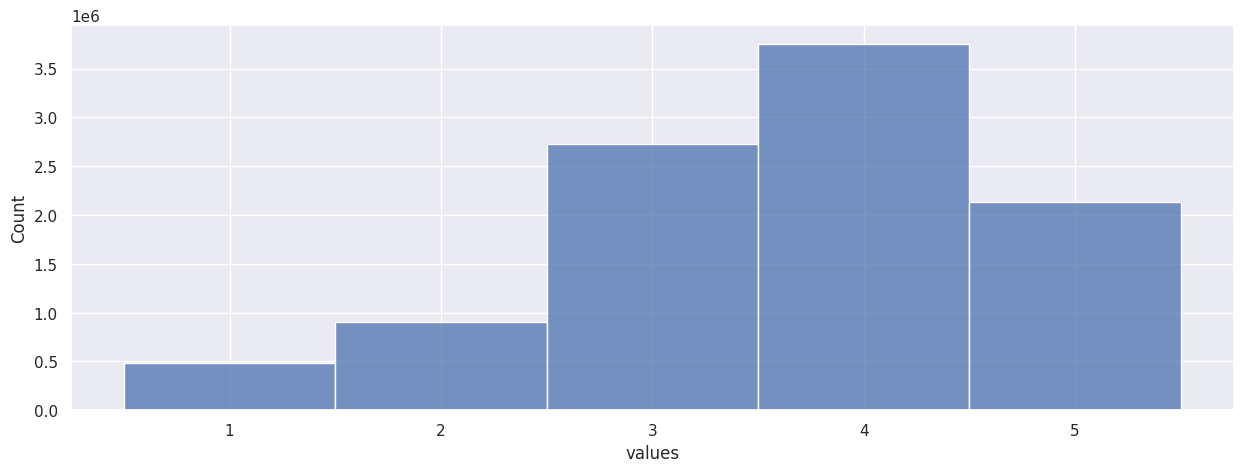

In [8]:
sns.histplot(data=ratings["values"], binwidth=1)
plt.show()

### 3: Построим Rating Distribution

Вы спросите, а что такое Rating Distribution?

Это просто fancy название графика, который, грубо говоря, показывает отношение количества рейтингов к количеству юзеров. Он отлично подходит, чтобы popularity-skew в данных.

По оси y располагаем количество рейтингов, выраженное в процентах от общего количества.
По оси x - айтемы сортированные в порядке убывания по количество рейтингов на них. Ну и также ставим для них в качестве id - процент.

In [9]:
def rating_distribution(column: str) -> None:
    # Compute
    ratings_dist = ratings[column].value_counts(normalize=True).reset_index()
    ratings_dist.columns = [column, "num_ratings_percent"]
    step = 1 / (ratings_dist.shape[0] - 1)
    ratings_dist[f"{column}_percent"] = np.arange(0, 1 + step, step) * 100
    ratings_dist["num_ratings_percent"] = np.cumsum(ratings_dist["num_ratings_percent"]) * 100
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(data=ratings_dist, x=f"{column}_percent", y="num_ratings_percent", ax=ax)
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 2))
    ax.set_title("Rating Distribution")
    plt.show()

Для item

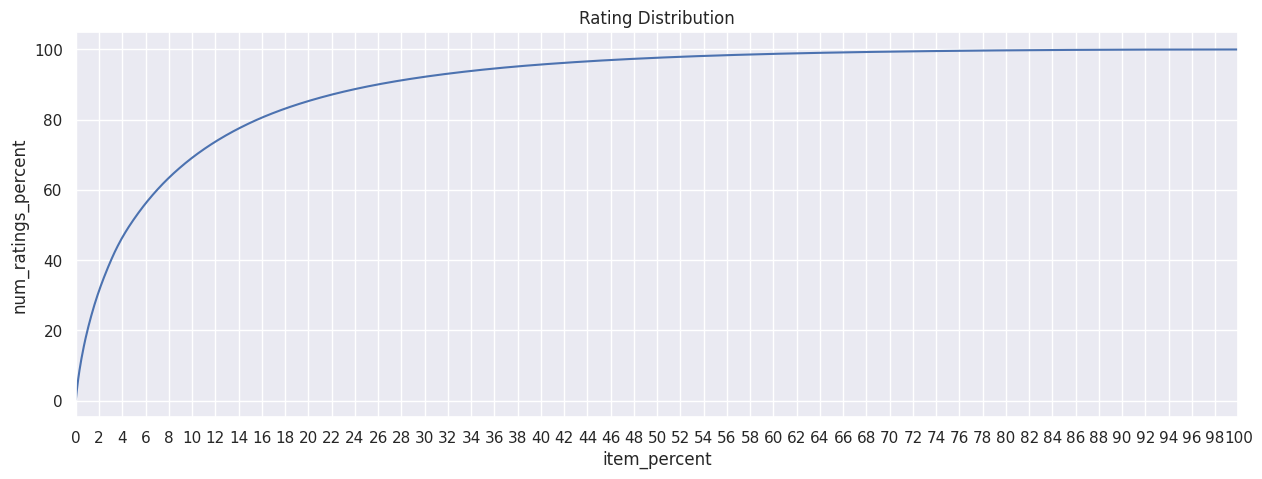

In [10]:
rating_distribution(column="item")

Для user

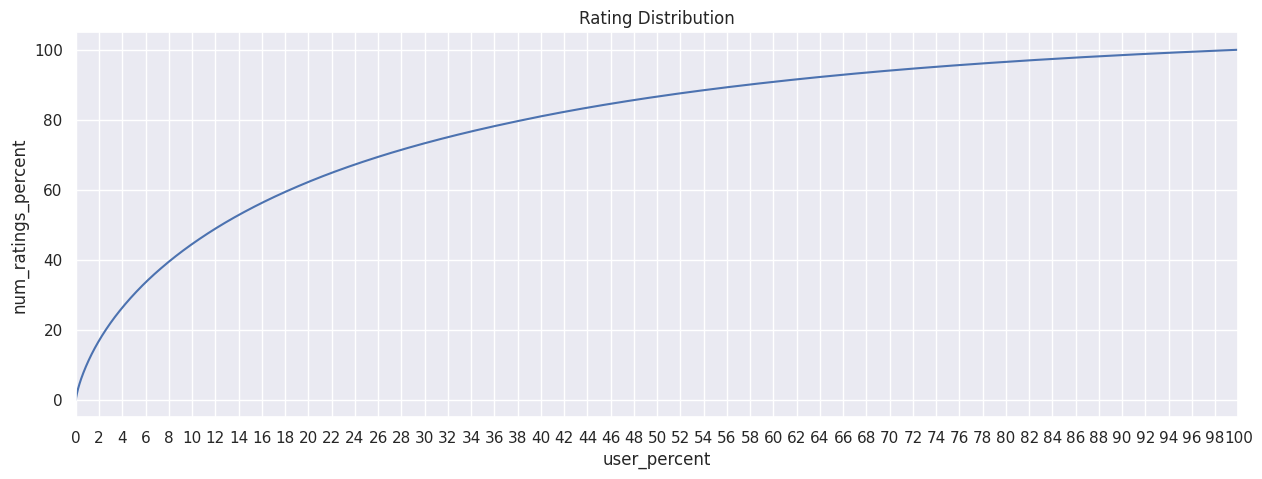

In [11]:
rating_distribution(column="user")

## Step 2: Мы почистим, мы помоем!

### 1: Сделаем простенькую фильтрацию

Ниже есть несколько удобных функций, с которыми можно поиграться:
- **valid_items**
    - получим элементы, которые встречаются реже чем threshold. Полезно, чтобы исключить супер популярные айтемы и активных юзеров.
- **filter_ratings**
    - оставим только рейтинги выше `min_rating` (полезно если хотим сделать implicit датасте)
    - оставим users и items, которые встречаются не реже `min_user_count`, `min_item_count` соответственно. 

In [12]:
def valid_elements(data: pd.DataFrame, column: str, threshold: float = 0.2) -> Set[int]:
    rating_dist = data[column].value_counts().reset_index()
    cut_off = round(threshold * rating_dist.shape[0]) + 1
    return set(rating_dist.index[cut_off:])


def get_count(data: pd.DataFrame, column: str) -> pd.DataFrame:
    grouped_by_column = data.groupby(column, as_index=False)
    return grouped_by_column.size()


def _filter_ratings(
    data: pd.DataFrame,
    min_rating: float = 3.0,
    min_user_count: int = 3,
    min_item_count: int = 3,
) -> pd.DataFrame:
    if min_rating is not None:
        data = data.loc[data["values"] > min_rating]
    if min_item_count > 0:
        itemcount = get_count(data, column="item")
        data = data.loc[data["item"].isin(itemcount.item[itemcount["size"] >= min_item_count])]
    if min_user_count > 0:
        usercount = get_count(data, column="user")
        data = data.loc[data["user"].isin(usercount.user[usercount["size"] >= min_user_count])]
    return data


def filter_ratings(
    data: pd.DataFrame,
    min_rating: float = 3.0,
    min_user_count: int = 3,
    min_item_count: int = 3,
    remove_top_items: float = 0.02,
) -> pd.DataFrame:
    if remove_top_items > 0:
        valid_items = valid_elements(data, column="item")
        data = data.loc[data["item"].isin(valid_items)]
    while True:
        cur_num_rows = data.shape[0]
        data = _filter_ratings(data, min_rating, min_user_count, min_item_count)
        new_num_rows = data.shape[0]
        if cur_num_rows == new_num_rows:
            break
    return data

In [13]:
implicit_filtered_ratings = filter_ratings(ratings)
print(f"Before: {ratings.shape}; After: {implicit_filtered_ratings.shape}")
explicit_filtered_ratings = filter_ratings(ratings, min_rating=None)
print(f"Before: {ratings.shape}; After: {explicit_filtered_ratings.shape}")

Before: (10000054, 4); After: (2335323, 4)
Before: (10000054, 4); After: (3996480, 4)


### 2: Построим encoder для user и item

Вместо кастомного encoder можно использовать [sklearn.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), однако `pickle зло` поэтому напишем свой.

In [14]:
@dataclass
class NamespaceEncoder:
    item_to_idx: dict[str, int] = field(default_factory=dict)
    idx_to_item: dict[str, str] = field(default_factory=dict)

    def __post_init__(self) -> None:
        self.add("@@OOV@@")

    def __len__(self) -> int:
        return len(self.item_to_idx)

    def add(self, item: str) -> None:
        idx = len(self.item_to_idx)
        self.item_to_idx[item] = idx
        self.idx_to_item[str(idx)] = item


class Encoder:
    def __init__(self) -> None:
        self.namespaces = {"user": NamespaceEncoder(), "item": NamespaceEncoder()}

    def encode(self, data: Iterable[str], namespace: str = "user") -> list[str]:
        encoder = self.namespaces[namespace].item_to_idx
        return [encoder.get(x, 0) for x in data if x in encoder]

    def decode(self, data: Iterable[Union[str, int]], namespace: str = "user") -> list[str]:
        decoder = self.namespaces[namespace].idx_to_item
        return [decoder.get(x, "@@OOV@@") for x in map(str, data) if x in decoder]

    def fit(self, data: pd.DataFrame) -> "Encoder":
        for attr, encoder in self.namespaces.items():
            for item in data[attr].unique():
                encoder.add(item)
        return self

    def transform(self, data: pd.DataFrame, decode: bool = False) -> pd.DataFrame:
        data_copy = data.copy()
        data_copy = data_copy[
            data_copy.user.isin(set(self.namespaces["user"].item_to_idx))
            & data_copy.item.isin(set(self.namespaces["item"].item_to_idx))
        ]
        for attr in self.namespaces:
            func = self.encode if not decode else self.decode
            data_copy[attr] = func(data_copy[attr].values, namespace=attr)
        return data_copy

In [15]:
encoder = Encoder().fit(explicit_filtered_ratings)
implicit_filtered_ratings = encoder.transform(implicit_filtered_ratings)
explicit_filtered_ratings = encoder.transform(explicit_filtered_ratings)

### 3: Выберем себе тестовые данные

Вот просто так, решили, что для тестирования наших рекомендов возьмём последний **год** из базы. На остальном будем обучаться.

Необязательно подходить именно таким образом для создания тестового и валидационного датасетов.

In [16]:
ts_split = {
    "implicit": implicit_filtered_ratings["timestamp"].max() - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_ratings["timestamp"].max() - pd.Timedelta(365, "days"),
}
datasets = {}
for key, dataset in (("implicit", implicit_filtered_ratings), ("explicit", explicit_filtered_ratings)):
    datasets[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets[key]["valid"] = datasets[key]["valid"].loc[datasets[key]["valid"].user.isin(datasets[key]["train"].user.unique())]

In [17]:
def make_sparse(dataset: pd.DataFrame, encoder: Encoder, binary: bool = False) -> sps.csr_matrix:
    shape = len(encoder.namespaces["user"]), len(encoder.namespaces["item"])
    values = dataset["values"].to_numpy()
    values = np.ones_like(values) if binary else values
    return sps.csr_matrix((values, (dataset["user"].to_numpy(), dataset["item"].to_numpy())), shape=shape)

In [18]:
def build_sparse_datasets(
    train: pd.DataFrame, valid: pd.DataFrame, encoder: Encoder, binary: bool = True
) -> dict[str, sps.csr_matrix]:
    train_sparse = make_sparse(train, encoder, binary=binary)
    valid_sparse = make_sparse(valid, encoder, binary=binary)
    train_mask, valid_mask = train_sparse.getnnz(axis=-1) > 0, valid_sparse.getnnz(axis=-1) > 0
    return {
        "train": {"source": train_sparse[train_mask], "target": train_sparse[train_mask]},
        "valid": {"source": train_sparse[valid_mask], "target": valid_sparse[valid_mask]},
    }

In [19]:
from pprint import pprint


explicit_datasets = build_sparse_datasets(**datasets["explicit"], encoder=encoder, binary=False)
implicit_datasets = build_sparse_datasets(**datasets["implicit"], encoder=encoder, binary=True)
print("Explicit")
pprint(explicit_datasets)
print("Implicit")
pprint(implicit_datasets)

Explicit
{'train': {'source': <41597x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 3677956 stored elements in Compressed Sparse Row format>,
           'target': <41597x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 3677956 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 633168 stored elements in Compressed Sparse Row format>,
           'target': <2369x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <40613x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 2125713 stored elements in Compressed Sparse Row format>,
           'target': <40613x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 2125713 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2259x6197 sparse matrix of type '<class 'numpy.float64'>'
	with 345760 stored elements in Co

## 4: Обучим модельки

Сразу будем писать всё на torch, because we can!!!

In [20]:
class MovieLensDataset(Dataset):
    def __init__(self, source: sps.csc_matrix, target: sps.csr_matrix = None) -> None:
        self._source = source
        self._target = target

    def __len__(self):
        return self._source.shape[0]

    def __getitem__(self, idx: int) -> dict[str, np.ndarray]:
        item = {"source": self._source[idx]}
        if self._target is not None:
            item["target"] = self._target[idx]
        return item

In [21]:
class MovieLensCollator:
    def __call__(self, instances: Iterable[dict[str, sps.csr_matrix]]) -> dict[str, torch.Tensor]:
        batch = self._make_batch(instances)
        for key, tensor in batch.items():
            batch[key] = (
                self._to_sparse(tensor).to_dense().float()
                if isinstance(tensor[0], sps.csr_matrix)
                else torch.Tensor(tensor)
            )
        return dict(batch)

    @staticmethod
    def _make_batch(instances: Iterable[dict[str, sps.csr_matrix]]) -> dict[str, list[sps.csr_matrix]]:
        tensor_dict = defaultdict(list)
        for instance in instances:
            for field, tensor in instance.items():
                tensor_dict[field].append(tensor)
        return tensor_dict

    @staticmethod
    def _to_sparse(tensor: list[sps.csr_matrix]) -> torch.sparse.Tensor:
        tensor = sps.vstack(tensor)
        values = torch.from_numpy(tensor.data)
        indices = torch.from_numpy(np.vstack(tensor.nonzero())).long()
        sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
        return sparse_tensor

### Sparse Model и Runner

#### Model

Каждая модель состоит из 2 функции:
- Обучение (_fit_). Каждая модель обучается только на `train.source` части из датасетов.
- Инфер (_predict_proba_). Делаем инфер на батче данных из `(train|valid).source` и сравниваем с ответами в `(train|valid).target`, если добавили callback с метриками. Ответ каждой модели - словарь. Мы решили остановиться на dict только с одним ключом **logits**. Однако никто не запрещает добавить что-то ещё. Это очень хорошая практика, когда forward или predict_proba возвращает словарь.

И да ещё один важный момент. У каждой модели есть параметр `remove_seen`. С помощью него из предсказний модели, можно убрать айтемы, которые юзер видел во время обучения. В итоге мы всегда будем рекомендовать только что-то новое для клиентов.

#### Runner

Runner решает только одну задачу - прогон модели на данных. _Fit_ делаем на всех данных, а _predict_proba_ батчевым образом, чтобы сэкономить на памяти.

In [22]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
class SparseModel(ABC):
    def __init__(self, remove_seen: bool = True) -> None:
        self.remove_seen = remove_seen
        self.device = torch.device("cpu")

    @abstractmethod
    def fit(self, data: sps.csr_matrix) -> None:
        pass

    @abstractmethod
    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        pass

    def to(self, device: torch.device) -> "SparseModel":
        self.device = device
        return self

In [24]:
class SparseRunner(IExperiment):
    def __init__(
        self,
        model: SparseModel,
        seed: int = 13,
        batch_size: int = 32,
        device: torch.device = torch.device("cpu"),
        callbacks: dict[str, ICallback] = None,
        target_threshold: float = 0.0,
    ) -> None:
        super().__init__()
        self.seed = seed
        self.model = model.to(device)
        self.device = device
        self.callbacks = callbacks or defaultdict(None)
        self._batch_size = batch_size
        self._target_threshold = target_threshold
        # Extra variables
        self.batch_output: dict[str, torch.Tensor] = None
        self.batch_target: torch.Tensor = None

    def run_dataset(self) -> None:
        if self.is_train_dataset:
            self.model.fit(self.dataset["source"])
        self.dataset = tqdm(
            DataLoader(
                MovieLensDataset(**self.dataset),
                collate_fn=MovieLensCollator(),
                batch_size=self._batch_size,
                shuffle=True,
                num_workers=1,
                pin_memory=True,
            ),
            desc=f"Iterating {self.dataset_key}",
        )
        # Remove seen items only for validation
        self.model.remove_seen = not self.is_train_dataset
        super().run_dataset()

    def run_batch(self) -> None:
        self.batch = {k: v.to(self.device) for k, v in self.batch.items()}
        self.batch_target = self.batch["target"].gt(self._target_threshold).float()
        self.batch_output = self.model.predict_proba(self.batch)

    def run(self, datasets: dict[str, dict[str, sps.csr_matrix]]) -> None:
        self.datasets = datasets
        super().run()

In [25]:
dataset_example_train = MovieLensDataset(**implicit_datasets['train'])

In [26]:
loader_example = DataLoader(
                dataset_example_train,
                collate_fn=MovieLensCollator(),
                batch_size=32,
                shuffle=True,
                num_workers=1,
                pin_memory=True,
            )

In [27]:
next(iter(loader_example))

{'source': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]),
 'target': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]])}

In [28]:
device

device(type='cuda', index=0)

### Baselines

Здесь мы построим модель TopPopular. Уверен, многим из вас эта модель знакома. Да даже если и не знакома, по названию очень просто догадаться как тут всё работает. Однако мы всё равно это опишем.
1. Получим список самых популярных айтемов по суммированию интеракций. Тут не будет никакой разницы между explicit и implicit, просто суммируем значение интеракции для каждого айтема.

In [29]:
class TopPopularModel(SparseModel):
    def __init__(self, remove_seen: bool = True) -> None:
        super().__init__(remove_seen=remove_seen)
        self._stats = {}

    def fit(self, data: sps.csr_matrix) -> None:
        self._stats["item_freq"] = self._logits = torch.from_numpy(
            np.array(data.sum(axis=0), dtype=np.float32)
        ).view(-1).to(self.device)

    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        scores = self._logits.repeat(batch["source"].size(0), 1)
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [30]:
top_popular = SparseRunner(model=TopPopularModel(), device=device)
print("Implicit")
top_popular.run(implicit_datasets)
print("Explicit")
top_popular.run(explicit_datasets)

Implicit


Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 79.01it/s]


Explicit


Iterating valid: 100%|██████████| 75/75 [00:00<00:00, 77.59it/s]


### KNNModel

Здесь в одной модели мы решили объединить сразу 2 типа KNN алгоритмов:
- user-based
- item-based

Извините, но тут действительно проще всего описать формулками

Сначала обозначим:
- $v \sim S_k(u;i)$ - список юзеров $v$, которые взаимодействовали с айтемом $i$ и которые похожи на юзера $u$. Таких юзеров будет не больше чем $k$ (отсюда название).
- $j \sim S_k(u;i)$ - список айтемов $j$, с которыми юзер $u$ взаимодействовал и которые похожи на $i$. Таких айтемов будет не больше чем $k$.
- $s_{ab}$ - значение similarity между $a$ и $b$.

Так-с основные определения готовы, теперь опишем как сделать предсказания для каждой модельки:
- user-based
$$
\hat{r}_{ui} = \frac{\sum_{v \sim S_k(u;i)}s_{uv} \cdot r_{vi}}{\sum_{v \sim S_k(u;i)}s_{uv}}
$$
- item-based
$$
\hat{r}_{ui} = \frac{\sum_{j \sim S_k(u;i)}s_{ij} \cdot r_{uj}}{\sum_{j \sim S_k(u;i)}s_{ij}}
$$

Btw, знаменатель можно опустить, если нам неважно значение $r_{ui}$ и лишь достаточно правильно ранжировать. Тогда формулки становится ещё проще:
- user-based: $\hat{R} = WR$, где $R \in \text{(num users) x (num items)}$, $W \in \text{(num users) x (num users)}$
- item-based: $\hat{R} = RW$, где $R \in \text{(num users) x (num items)}$, $W \in \text{(num items) x (num items)}$

Теперь опишем основные подходы для подсчёта значения $s_{ab}$. Можно выделить 3 типа:
- поставим ручками самостоятельно
- воспользуемся метриками: euclidean, jaccard, cosine, etc
- обучим матрицу $W$

In [31]:
class KNNModel(SparseModel):
    def __init__(
        self,
        similarity: str,
        topk: int,
        count_threshold: int = None,
        method: str = "item",
        remove_seen: bool = True,
    ) -> None:
        super().__init__(remove_seen=remove_seen)
        assert similarity in ("cooccurrence", "cosine", "jaccard")
        self._similarity = getattr(self, similarity)
        self._topk = topk
        self._count_threshold = count_threshold
        self._method = method

    def cooccurrence(self, data: sps.csr_matrix) -> torch.Tensor:
        if self._method == "user":
            # sim_matrix ~ (num users, num users)
            sim_matrix = torch.from_numpy(data.dot(data.T).toarray()).to(self.device)
        else:
            # sim_matrix ~ (num items, num items)
            sim_matrix = torch.from_numpy(data.T.dot(data).toarray()).to(self.device)
        if self._count_threshold is not None:
            sim_matrix *= sim_matrix > self._count_threshold
        return sim_matrix

    def cosine(self, data: sps.csr_matrix) -> torch.Tensor:
        if self._method == "user":
            # sim_matrix ~ (num users, num users)
            sim_matrix = torch.from_numpy(data.dot(data.T).toarray()).to(self.device)
            # sum_of_squares ~ (num users)
            sum_of_squares = torch.from_numpy(
                data.power(2).sum(axis=1)
            ).to(self._device).view(-1).sqrt()
        else:
            # sim_matrix ~ (num items, num items)
            sim_matrix = torch.from_numpy(data.T.dot(data).toarray()).to(self.device)
            # sum_of_squares ~ (num items)
            sum_of_squares = torch.from_numpy(
                data.power(2).sum(axis=0)
            ).to(self.device).view(-1).sqrt()
        if self._count_threshold is not None:
            sim_matrix *= sim_matrix > self._count_threshold
        denominator = torch.einsum("i,j->ij", sum_of_squares, sum_of_squares) + 1e-13
        sim_matrix = sim_matrix / denominator
        sim_matrix.fill_diagonal_(0.0)
        return sim_matrix

    def jaccard(self, data: sps.csr_matrix) -> torch.Tensor:
        if self._method == "user":
            # intersection ~ (num users, num users)
            intersection = torch.from_numpy(data.dot(data.T).toarray()).to(self.device)
        else:
            # intersection ~ (num items, num items)
            intersection = torch.from_numpy(data.T.dot(data).toarray()).to(self.device)
        if self._count_threshold is not None:
            intersection *= intersection > self._count_threshold
        diagonal = intersection.diagonal()
        return intersection / (diagonal.unsqueeze(0) + diagonal.unsqueeze(-1) - intersection)

    def fit(self, data: sps.csr_matrix) -> None:
        topk = min(self._topk or data.shape[-1] - 1, data.shape[-1] - 1)
        similarity_matrix = self._similarity(data).float()
        relevant = torch.topk(similarity_matrix, k=topk, dim=-1)
        self._similarity_matrix = torch.zeros_like(similarity_matrix).scatter_(
            dim=-1, index=relevant.indices, src=relevant.values
        )

    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        scores = torch.einsum("bi,ij->bj", batch["source"], self._similarity_matrix)
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [32]:
knn_model = SparseRunner(model=KNNModel("cosine", topk=100), device=device)
print("Implicit")
knn_model.run(implicit_datasets)
print("Explicit")
knn_model.run(explicit_datasets)

Implicit


Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 71.00it/s]


Explicit


Iterating valid: 100%|██████████| 75/75 [00:00<00:00, 78.46it/s]


### EASE

Эта умная KNN моделька

В Markdown не получится объяснять структуру модели, поэтому предлагаем вам заценить [статью](https://arxiv.org/abs/1905.03375). Она очень даже хорошая, а интерпретация модели - наше почтение.

In [33]:
class EASE(SparseModel):
    def __init__(self, remove_seen: bool = True, lambda_weight: float = 100.0) -> None:
        super().__init__(remove_seen=remove_seen)
        self._lambda_weight = lambda_weight
        self._item_matrix = None

    def fit(self, data: sps.csr_matrix) -> None:
        X = torch.sparse.FloatTensor(
            torch.from_numpy(np.vstack(data.nonzero())).long(),
            torch.from_numpy(data.data),
            data.shape,
        )
        # Вот тут вместо cooccurrence matrix можно попробовать cosine или corr
        gram_matrix = torch.sparse.mm(X.transpose(0, 1), X)
        gram_matrix += self._lambda_weight * torch.eye(gram_matrix.shape[0]).to_sparse()
        gram_matrix = gram_matrix.to_dense().to(self.device)
        precision_matrix = torch.linalg.inv(gram_matrix)
        item_matrix = precision_matrix / (-torch.diag(precision_matrix))
        item_matrix.fill_diagonal_(0.0)
        self._item_matrix = item_matrix.float()

    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        scores = torch.einsum("bi,ij->bj", batch["source"], self._item_matrix)
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [34]:
runner = SparseRunner(model=EASE(), batch_size=512, device=device)
runner.run(implicit_datasets)

<ipython-input-33-44e2fceec71e>:14: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  gram_matrix = torch.sparse.mm(X.transpose(0, 1), X)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


### SVD

Ойойой. Думаю вам всем знакома эта модель, поэтому описывать её устройства не будем. Разве что только поговорим про инфер.

Кмк в последних статьях с модельками для explicit данных вы не найдёте бенчмарком с этим типом моделей. Оно и понятно, SVD показывает скромные результаты для предсказания рейтинга $r_{ui}$. Однако SVD обладает хорошими ранжирующими качествами. А для нас это важнее всего))

Ладно, теперь про инфер. В `predict_proba` мы воспользуемся ортогональностью матриц $U \sim R^{\text{(num users) x (factors)}}$ и $V \sim R^{\text{(num items) x (factors)}}$. Благодаря этому инфер можно записать вот так: $\hat{r}_u = r_u \cdot V \cdot V^T$

In [35]:
class SvdModel(SparseModel):
    def __init__(self, factors: int, remove_seen: bool = True) -> None:
        super().__init__(remove_seen=remove_seen)
        self._factors = factors
        self.factors = {}
        self.sigma = None

    def fit(self, data: sps.csr_matrix) -> None:
        # Torch argues on negative stride with u and sigma
        u, sigma, vt = sps.linalg.svds(data, k=self._factors)
        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum("fi->if", torch.from_numpy(vt).float().to(self.device)),
        }
        self.sigma = torch.from_numpy(sigma.copy()).diag().float().to(self.device)

    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [41]:
runner = SparseRunner(model=SvdModel(factors=128), batch_size=512, device=device)
print("Implicit")
runner.run(implicit_datasets)
print("Explicit")
runner.run(explicit_datasets)

Implicit


Iterating valid: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


Explicit


Iterating valid: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


## 5: Считаем метрички

Метрики precision, recall, m(n)ap и ndcg (необязательно) считают для бинарного таргета. Поэтому в коде `SparseRunner` вы могли заметить перевод `batch_target` в бинарный формат независимо от implicit или explicit фидбэка. На 1 лекции мы поговорили о важной особенности метрик в RecSys - считаем всё для какого-то top at k.

Снова немножко формул:
- $target_{sort}$ - таргет, сортированный в соответствии с логитами модели по убыванию


Так как, мы всё делаем поверху animus, сделаем 2 callback, чтобы красиво визуализировать метрики моделей

In [36]:
class MetricCallback(ICallback):
    def __init__(self, func: Callable, topk: list[int], input_key: str) -> None:
        self._name = func.__name__
        self._func = func
        self._topk = topk
        self._input_key = input_key
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def _get_metric(self) -> dict[str, float]:
        return {
            f"{self._name}@{k}": metric_sum / self._num_batches
            for k, metric_sum in self._total_sum.items()
        }

    def on_dataset_start(self, exp: IExperiment) -> None:
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def on_batch_end(self, exp: IExperiment) -> None:
        for k in self._topk:
            self._total_sum[k] += self._func(
                exp.batch_output[self._input_key], exp.batch_target, topk=k
            ).item()
        self._num_batches += 1
        exp.batch_metrics.update(self._get_metric())

    def on_dataset_end(self, exp: IExperiment) -> None:
        exp.dataset_metrics.update(self._get_metric())

In [37]:
class LoggerCallback(ICallback):
    def on_dataset_end(self, exp: IExperiment) -> None:
        """Run callbacks on dataset end."""
        print(f"{exp.dataset_key.capitalize()} metrics:")
        max_length = max(len(x) for x in exp.dataset_metrics)
        # Sort by length to make it prettier
        for metric in sorted(exp.dataset_metrics, key=self._sort_func):
            metric_value = exp.dataset_metrics.get(metric)
            if isinstance(metric_value, (float, int)):
                print(f"{metric.ljust(max_length)} | {metric_value:.4f}")

    @staticmethod
    def _sort_func(x: str) -> Tuple[int, str, int]:
        if "@" in x:
            metric_key, topk = x.split("@")
            return (len(metric_key), metric_key, int(topk))
        return (len(x), x, 0)

In [38]:
class PrepareTargetResult(NamedTuple):
    values: torch.Tensor
    indices: torch.Tensor


def validate_metric_inputs(output: torch.Tensor, target: torch.Tensor) -> None:
    if output.size() != target.size():
        raise IndexError(
            "Unequal sizes for output and target: "
            f"output - {output.size()}, target - {target.size()}."
        )
    if not (target.eq(0) | target.eq(1)).all():
        raise ValueError(
            "Target contains values outside of 0 and 1." f"\nTarget:\n{target}"
        )


def prepare_target(
    output: torch.Tensor, target: torch.Tensor, return_indices: bool = False
) -> Union[torch.Tensor, PrepareTargetResult]:
    validate_metric_inputs(output, target)
    # Define order by sorted output scores.
    indices = output.argsort(dim=-1, descending=True)
    sorted_target = torch.gather(target, index=indices, dim=-1)
    return (
        PrepareTargetResult(sorted_target, indices) if return_indices else sorted_target
    )


def nan_to_num(tensor: torch.Tensor, nan: float = 0.0) -> torch.Tensor:
    return torch.where(
        torch.isnan(tensor) | torch.isinf(tensor),
        torch.full_like(tensor, fill_value=nan),
        tensor,
    )

In [39]:
output, target = torch.randn(size=(10, 13)), torch.randint(low=0, high=2, size=(10, 13)).float()

### Precision

$$
p@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{k}
$$

In [40]:
def precision(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # precision_score ~ (users)
    precision_score = target_sorted_by_output.sum(dim=-1) / topk
    return precision_score.mean()

In [41]:
precision(output, target, topk=3)

tensor(0.4667)

### Recall

$$
r@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{\sum target}
$$

In [42]:
def recall(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.shape[-1], topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # recall_score ~ (users)
    recall_score = nan_to_num(
        target_sorted_by_output.sum(dim=-1) / target.sum(dim=-1)
    )
    return recall_score.mean()

In [43]:
recall(output, target, topk=3)

tensor(0.2017)

### Mean (Normalized) Average Precision

$ap@k = \frac{1}{\sum_{i=1}^k{target_{sort}[i]}} \sum_{i=1}^k target_{sort}[i] \cdot p@i$
```python
map@k = reduce(ap@k, "users->", reduction="mean")
```

In [44]:
def mnap(output: torch.Tensor, target: torch.Tensor, topk: int, normalized: bool = True) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # target_cumsum ~ (users, topk)
    target_cumsum = target_sorted_by_output.cumsum(dim=-1)
    # topk_tensor ~ (topk)
    topk_tensor = torch.arange(0, topk, dtype=torch.long, device=output.device)
    # precisions ~ (users, topk)
    precisions = target_cumsum / (topk_tensor + 1.0)
    # relevant_precisions ~ (users, topk)
    relevant_precisions = precisions * target_sorted_by_output
    # Add  normalization if needed
    denominator = target.sum(dim=-1).clamp(max=topk) if normalized else target_sorted_by_output.sum(dim=-1)
    # ap_score ~ (users)
    ap_score = nan_to_num(relevant_precisions.sum(dim=-1) / denominator)
    return ap_score.mean()

In [45]:
mnap(output, target, topk=3)

tensor(0.3556)

### Normalized Discounted Cumulative Gain

- Cumulative Gain (CG): $CG@k = \sum_{i=1}^k target_{sort}[i]$
- Discounted Cumulative Gain (DCG): $DCG@k = \sum_{i=1}^k \frac{2^{target_{sort}[i]} - 1}{\log(i + 1)}$
- Normalized Discounted Cumulative Gain (nDCG): $nDCG@k = \frac{DCG@k}{idealDCG@k}$

In [46]:
def dcg(tensor: torch.Tensor) -> torch.Tensor:
    gains = (2**tensor) - 1
    return gains / torch.log2(torch.arange(0, tensor.size(-1), dtype=torch.float, device=tensor.device) + 2.0)


def ndcg(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, items)
    target_sorted_by_output = prepare_target(output, target)
    ideal_target = prepare_target(target, target)
    # ideal_dcg ~ (users, topk)
    ideal_dcg = dcg(ideal_target)[:, :topk]
    # prediction_dcg ~ (users, topk)
    prediction_dcg = dcg(target_sorted_by_output)[:, :topk]
    # ideal_dcg_cumsum ~ (users)
    ideal_dcg_score = ideal_dcg.sum(dim=-1)
    # prediction_dcg_cumsum ~ (users)
    prediction_dcg_score = prediction_dcg.sum(dim=-1)
    # ndcg_score ~ (users, items)
    ndcg_score = nan_to_num(prediction_dcg_score / ideal_dcg_score)
    # ndcg_score[ideal_dcg_score.eq(0)] = 0.0
    return ndcg_score.mean()

In [47]:
ndcg(output, target, topk=3)

tensor(0.4531)

## LESSS GOOOOOO

### Top Popular

In [54]:
runner = SparseRunner(
    model=TopPopularModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner.run(explicit_datasets)

Iterating train: 100%|██████████| 82/82 [06:04<00:00,  4.45s/it]


Train metrics:
mnap@1       | 0.4153
mnap@3       | 0.3329
mnap@10      | 0.2149
ndcg@1       | 0.4153
ndcg@3       | 0.3985
ndcg@10      | 0.3295
recall@1     | 0.0155
recall@3     | 0.0429
recall@10    | 0.0957
precision@1  | 0.4153
precision@3  | 0.3918
precision@10 | 0.2948


Iterating valid: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]

Valid metrics:
mnap@1       | 0.1644
mnap@3       | 0.1105
mnap@10      | 0.0736
ndcg@1       | 0.1644
ndcg@3       | 0.1403
ndcg@10      | 0.1244
recall@1     | 0.0179
recall@3     | 0.0396
recall@10    | 0.0783
precision@1  | 0.1644
precision@3  | 0.1270
precision@10 | 0.0916


In [55]:
runner = SparseRunner(
    model=TopPopularModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|██████████| 80/80 [05:15<00:00,  3.94s/it]


Train metrics:
mnap@1       | 0.4243
mnap@3       | 0.3400
mnap@10      | 0.2214
ndcg@1       | 0.4243
ndcg@3       | 0.4069
ndcg@10      | 0.3361
recall@1     | 0.0153
recall@3     | 0.0427
recall@10    | 0.0958
precision@1  | 0.4243
precision@3  | 0.4005
precision@10 | 0.3017


Iterating valid: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]

Valid metrics:
mnap@1       | 0.1407
mnap@3       | 0.0960
mnap@10      | 0.0660
ndcg@1       | 0.1407
ndcg@3       | 0.1228
ndcg@10      | 0.1133
recall@1     | 0.0151
recall@3     | 0.0337
recall@10    | 0.0737
precision@1  | 0.1407
precision@3  | 0.1125
precision@10 | 0.0854


### Item KNN

In [56]:
runner = SparseRunner(
    model=KNNModel("cosine", topk=100),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|██████████| 80/80 [04:15<00:00,  3.19s/it]


Train metrics:
mnap@1       | 0.3266
mnap@3       | 0.2944
mnap@10      | 0.2370
ndcg@1       | 0.3266
ndcg@3       | 0.3400
ndcg@10      | 0.3327
recall@1     | 0.0060
recall@3     | 0.0215
recall@10    | 0.0759
precision@1  | 0.3266
precision@3  | 0.3436
precision@10 | 0.3293


Iterating valid: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

Valid metrics:
mnap@1       | 0.1543
mnap@3       | 0.1077
mnap@10      | 0.0784
ndcg@1       | 0.1543
ndcg@3       | 0.1389
ndcg@10      | 0.1371
recall@1     | 0.0145
recall@3     | 0.0363
recall@10    | 0.0964
precision@1  | 0.1543
precision@3  | 0.1306
precision@10 | 0.1084


In [57]:
runner = SparseRunner(
    model=KNNModel("cosine", topk=100),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(explicit_datasets)

Iterating train: 100%|██████████| 82/82 [04:33<00:00,  3.33s/it]


Train metrics:
mnap@1       | 0.3966
mnap@3       | 0.3628
mnap@10      | 0.3171
ndcg@1       | 0.3966
ndcg@3       | 0.4101
ndcg@10      | 0.4142
recall@1     | 0.0053
recall@3     | 0.0181
recall@10    | 0.0675
precision@1  | 0.3966
precision@3  | 0.4138
precision@10 | 0.4156


Iterating valid: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

Valid metrics:
mnap@1       | 0.2139
mnap@3       | 0.1589
mnap@10      | 0.1119
ndcg@1       | 0.2139
ndcg@3       | 0.1981
ndcg@10      | 0.1824
recall@1     | 0.0155
recall@3     | 0.0383
recall@10    | 0.0950
precision@1  | 0.2139
precision@3  | 0.1901
precision@10 | 0.1523


### EASE

In [48]:
runner = SparseRunner(
    model=EASE(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]


Train metrics:
mnap@1       | 0.6144
mnap@3       | 0.5607
mnap@10      | 0.4630
ndcg@1       | 0.6144
ndcg@3       | 0.6106
ndcg@10      | 0.5688
recall@1     | 0.0212
recall@3     | 0.0646
recall@10    | 0.1767
precision@1  | 0.6144
precision@3  | 0.6089
precision@10 | 0.5411


Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

Valid metrics:
mnap@1       | 0.1718
mnap@3       | 0.1191
mnap@10      | 0.0845
ndcg@1       | 0.1718
ndcg@3       | 0.1545
ndcg@10      | 0.1496
recall@1     | 0.0169
recall@3     | 0.0429
recall@10    | 0.1050
precision@1  | 0.1718
precision@3  | 0.1450
precision@10 | 0.1157


### SVD

In [49]:
runner = SparseRunner(
    model=SvdModel(factors=32),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(explicit_datasets)

Iterating train: 100%|██████████| 82/82 [00:13<00:00,  6.04it/s]


Train metrics:
mnap@1       | 0.9412
mnap@3       | 0.8383
mnap@10      | 0.6661
ndcg@1       | 0.9412
ndcg@3       | 0.8760
ndcg@10      | 0.7674
recall@1     | 0.0371
recall@3     | 0.0901
recall@10    | 0.2037
precision@1  | 0.9412
precision@3  | 0.8568
precision@10 | 0.7066


Iterating valid: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

Valid metrics:
mnap@1       | 0.2407
mnap@3       | 0.1675
mnap@10      | 0.1156
ndcg@1       | 0.2407
ndcg@3       | 0.2108
ndcg@10      | 0.1919
recall@1     | 0.0199
recall@3     | 0.0433
recall@10    | 0.1006
precision@1  | 0.2407
precision@3  | 0.1979
precision@10 | 0.1559


In [50]:
runner = SparseRunner(
    model=SvdModel(factors=32),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|██████████| 80/80 [00:13<00:00,  6.10it/s]


Train metrics:
mnap@1       | 0.9450
mnap@3       | 0.8334
mnap@10      | 0.6396
ndcg@1       | 0.9450
ndcg@3       | 0.8716
ndcg@10      | 0.7470
recall@1     | 0.0573
recall@3     | 0.1359
recall@10    | 0.2765
precision@1  | 0.9450
precision@3  | 0.8495
precision@10 | 0.6550


Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

Valid metrics:
mnap@1       | 0.1417
mnap@3       | 0.1003
mnap@10      | 0.0706
ndcg@1       | 0.1417
ndcg@3       | 0.1330
ndcg@10      | 0.1300
recall@1     | 0.0140
recall@3     | 0.0355
recall@10    | 0.0912
precision@1  | 0.1417
precision@3  | 0.1264
precision@10 | 0.1012
